# Explore Sentinel-2

Import necessary packages.

In [67]:
import os
import xml.etree.ElementTree as ET
from datetime import datetime, timedelta
from PIL import Image
import matplotlib.pyplot as plt
from shapely.geometry import shape, Polygon, mapping
from shapely.ops import unary_union
import geopandas as gpd
import numpy as np
from pyproj import CRS, Transformer

## Setup: get tile footprint from images

Get Sentinel-2 tiling grid

In [4]:
!git clone https://github.com/justinelliotmeyers/Sentinel-2-Shapefile-Index.git

Cloning into 'Sentinel-2-Shapefile-Index'...
remote: Enumerating objects: 17, done.
remote: Total 17 (delta 0), reused 0 (delta 0), pack-reused 17 (from 1)
Receiving objects: 100% (17/17), 7.24 MiB | 20.03 MiB/s, done.
Resolving deltas: 100% (2/2), done.


In [5]:
tile_grid_shapefile = "./Sentinel-2-Shapefile-Index/sentinel_2_index_shapefile.shp"
tile_grid = gpd.read_file(tile_grid_shapefile)

In [6]:
print(tile_grid)

        Name                                           geometry
0      01CCV  POLYGON Z ((180.000 -73.060 0.000, 176.865 -72...
1      01CCV  POLYGON Z ((-180.000 -72.073 0.000, -179.627 -...
2      01CDH  POLYGON Z ((180.000 -83.809 0.000, 174.713 -83...
3      01CDH  POLYGON Z ((-180.000 -82.826 0.000, -176.297 -...
4      01CDJ  POLYGON Z ((180.000 -82.913 0.000, 175.748 -82...
...      ...                                                ...
56979  60XWP  POLYGON Z ((-180.000 80.140 0.000, -177.262 80...
56980  60XWQ  POLYGON Z ((180.000 80.052 0.000, 176.999 80.0...
56981  60XWQ  POLYGON Z ((-180.000 81.035 0.000, -176.697 81...
56982  60XWR  POLYGON Z ((180.000 80.948 0.000, 176.999 80.9...
56983  60XWR  POLYGON Z ((-180.000 81.931 0.000, -176.007 81...

[56984 rows x 2 columns]


In [75]:
# Define the tiles covering the South West UK
south_west_tiles = {"30UUA", "30UUB", "30UVB", "30UVA", "30UWB", "30UWA", "30UXB", "30UXA", "30UVC", "30UWC"}

In [109]:
tile_polygons = {tile: None for tile in south_west_tiles}

for tile_code in south_west_tiles:
    selected_tile = tile_grid[tile_grid['Name'] == tile_code]
    polygon = selected_tile.geometry.iloc[0]
    tile_polygons[tile_code] = polygon

Functions to get footprint

In [122]:
def get_footprint_from_safe(safe_path):
    """Extract footprint geometry from Sentinel-2 SAFE metadata"""
    mtd_file = os.path.join(safe_path, "MTD_MSIL2A.xml")
    tree = ET.parse(mtd_file)
    root = tree.getroot()

    # Extract the footprint polygon (WKT format) from the metadata
    for elem in root.iter():
        if "EXT_POS_LIST" in elem.tag:
            pos_list = elem.text.strip().split()
            coords = [(float(pos_list[i]), float(pos_list[i+1])) for i in range(0, len(pos_list), 2)]
            return Polygon(coords)
    return None

def calculate_coverage(image_footprint, tile_polygon):
    """Calculate coverage percentage of the tile."""
    if image_footprint is not None:
        # intersection = image_footprint.intersection(tile_polygon)
        # print(tile_polygon.area)
        coverage_percentage = (image_footprint.area / tile_polygon.area) * 100
        return coverage_percentage
    return None

def reproject_geometry(geometry, from_crs, to_crs):
    """Reproject a Shapely geometry from one CRS to another."""
    transformer = Transformer.from_crs(from_crs, to_crs, always_xy=True)
    return shape(transformer.transform(*geometry.exterior.xy))

# def plot_geometries(footprint, tile_polygon):
#     fig, ax = plt.subplots()
#     footprint_coords = np.array(mapping(footprint)["coordinates"][0])
#     footprint_patch = plt.Polygon(footprint_coords, edgecolor='blue', fill=False, label="Footprint")
#     tile_coords = np.array(mapping(tile_polygon)["coordinates"][0])[:,:2]
#     tile_patch = plt.Polygon(tile_coords, edgecolor='red', fill=False, label="Tile")
#     ax.add_patch(footprint_patch)
#     ax.add_patch(tile_patch)
#     plt.legend()
#     plt.show()

## Setup: get cloud coverage from images

In [113]:
# Cloud coverage threshold (e.g., max 10%)
max_cloud_coverage = 10.0

In [114]:
def get_cloud_coverage(safe_path):
    """Extract cloud coverage assessment from Sentinel-2 SAFE metadata"""
    mtd_file = os.path.join(safe_path, "MTD_MSIL2A.xml")
    tree = ET.parse(mtd_file)
    root = tree.getroot()
    cloud_coverage = root.find(".//Cloud_Coverage_Assessment")
    if cloud_coverage is not None:
        cloud_coverage_value = float(cloud_coverage.text)
        return cloud_coverage_value
    return None

## Extract and filter Sentinel-2 data

In [115]:
# Define the base path to Sentinel-2 data on WEkEO
base_path = "/home/jovyan/eodata/Sentinel-2/MSI/L2A"

# Define date range
start_date = datetime(2020, 6, 1)  # Starting date (YYYY, MM, DD)
end_date = datetime(2020, 6, 30)   # Ending date (YYYY, MM, DD)

# Define a dictionary to store paths of matched images
tile_safes = {tile: [] for tile in south_west_tiles}

In [125]:
# Loop through the dates in the specified range
current_date = start_date
while current_date <= end_date:
    # Format year, month, day as strings
    year = current_date.strftime("%Y")
    month = current_date.strftime("%m")
    day = current_date.strftime("%d")
    
    # Define the directory path
    folder_path = os.path.join(base_path, year, month, day)
    
    # Check if the directory exists
    if os.path.isdir(folder_path):
        # Loop through each folder in the day directory
        for folder_name in os.listdir(folder_path):
            # Check if the folder name contains a matching tile code
            for tile in south_west_tiles:
                if tile in folder_name:
                    # Form the path to the .SAFE folder
                    safe_path = os.path.join(folder_path, folder_name)

                    # Get tile coverage
                    image_footprint = get_footprint_from_safe(safe_path)
                    tile_coverage = calculate_coverage(image_footprint, tile_polygons[tile])
                    print(f"Tile coverage for {folder_name}: {tile_coverage}")

                    if tile_coverage is None or tile_coverage < 95:
                        break

                    # Get cloud coverage
                    cloud_coverage = get_cloud_coverage(safe_path)
                    print(f"Cloud coverage for {folder_name}: {cloud_coverage}")

                    if cloud_coverage is not None and cloud_coverage <= max_cloud_coverage:
                        print(f"Found data for tile {tile} on date {year}-{month}-{day}")
                        tile_safes[tile].append(safe_path)

                    # Found matching tile, move on to next SAFE folder
                    break
    
    # Move to the next day
    current_date += timedelta(days=1)

Tile coverage for S2A_MSIL2A_20200601T113331_N0214_R080_T30UUA_20200601T123416.SAFE: 90.16761306300623
Tile coverage for S2A_MSIL2A_20200601T113331_N0214_R080_T30UUB_20200601T123416.SAFE: 99.99972625007813
Cloud coverage for S2A_MSIL2A_20200601T113331_N0214_R080_T30UUB_20200601T123416.SAFE: 1.095431
Found data for tile 30UUB on date 2020-06-01
Tile coverage for S2A_MSIL2A_20200601T113331_N0214_R080_T30UVA_20200601T123416.SAFE: 4.214274276145964
Tile coverage for S2A_MSIL2A_20200601T113331_N0214_R080_T30UVB_20200601T123416.SAFE: 30.435935452167218
Tile coverage for S2A_MSIL2A_20200601T113331_N0214_R080_T30UVC_20200601T123416.SAFE: 60.840424115575786
Tile coverage for S2A_MSIL2A_20200602T105631_N0214_R094_T30UXA_20200602T135525.SAFE: 69.42810175676533
Tile coverage for S2A_MSIL2A_20200602T105631_N0214_R094_T30UXB_20200602T135525.SAFE: 48.829659186737985
Tile coverage for S2B_MSIL2A_20200603T112119_N0214_R037_T30UUA_20200603T145421.SAFE: 99.99955629566803
Cloud coverage for S2B_MSIL2A_202

Look at the last image

In [119]:
safe_path

'/home/jovyan/eodata/Sentinel-2/MSI/L2A/2020/06/01/S2A_MSIL2A_20200601T113331_N0214_R080_T30UUB_20200601T123416.SAFE'

In [120]:
safe_name = os.path.basename(safe_path)
safe_name

'S2A_MSIL2A_20200601T113331_N0214_R080_T30UUB_20200601T123416.SAFE'

Displaying image: /home/jovyan/eodata/Sentinel-2/MSI/L2A/2020/06/01/S2A_MSIL2A_20200601T113331_N0214_R080_T30UUB_20200601T123416.SAFE/S2A_MSIL2A_20200601T113331_N0214_R080_T30UUB_20200601T123416-ql.jpg


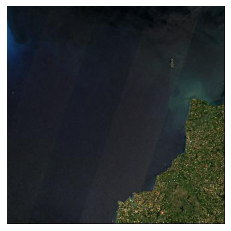

In [121]:
img_file_name = f"{safe_name[:-5]}-ql.jpg"
img_path = os.path.join(safe_path, img_file_name)
print(f"Displaying image: {img_path}")
with Image.open(img_path) as img:
    plt.imshow(img)
    plt.axis('off')
    plt.show()

Count how many images extracted for each tile

In [129]:
for key in tile_safes:
    print(f"{key}: {len(tile_safes[key])}")

30UVC: 1
30UWB: 2
30UUB: 1
30UVA: 1
30UWA: 1
30UVB: 1
30UXA: 1
30UUA: 1
30UWC: 1
30UXB: 1


Display all images found

Displaying image: /home/jovyan/eodata/Sentinel-2/MSI/L2A/2020/06/23/S2B_MSIL2A_20200623T112119_N0214_R037_T30UVC_20200623T143258.SAFE/S2B_MSIL2A_20200623T112119_N0214_R037_T30UVC_20200623T143258-ql.jpg


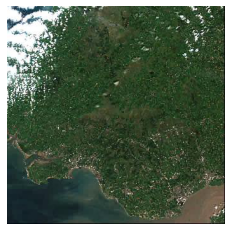

Displaying image: /home/jovyan/eodata/Sentinel-2/MSI/L2A/2020/06/23/S2B_MSIL2A_20200623T112119_N0214_R037_T30UWB_20200623T143258.SAFE/S2B_MSIL2A_20200623T112119_N0214_R037_T30UWB_20200623T143258-ql.jpg


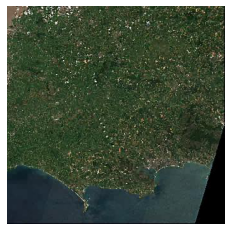

Displaying image: /home/jovyan/eodata/Sentinel-2/MSI/L2A/2020/06/25/S2A_MSIL2A_20200625T110631_N0214_R137_T30UWB_20200625T122333.SAFE/S2A_MSIL2A_20200625T110631_N0214_R137_T30UWB_20200625T122333-ql.jpg


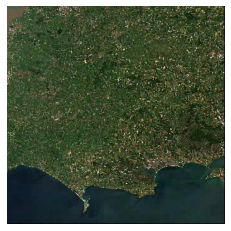

Displaying image: /home/jovyan/eodata/Sentinel-2/MSI/L2A/2020/06/01/S2A_MSIL2A_20200601T113331_N0214_R080_T30UUB_20200601T123416.SAFE/S2A_MSIL2A_20200601T113331_N0214_R080_T30UUB_20200601T123416-ql.jpg


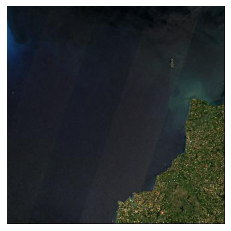

Displaying image: /home/jovyan/eodata/Sentinel-2/MSI/L2A/2020/06/23/S2B_MSIL2A_20200623T112119_N0214_R037_T30UVA_20200623T143258.SAFE/S2B_MSIL2A_20200623T112119_N0214_R037_T30UVA_20200623T143258-ql.jpg


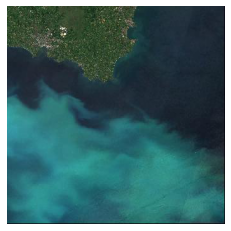

Displaying image: /home/jovyan/eodata/Sentinel-2/MSI/L2A/2020/06/25/S2A_MSIL2A_20200625T110631_N0214_R137_T30UWA_20200625T122333.SAFE/S2A_MSIL2A_20200625T110631_N0214_R137_T30UWA_20200625T122333-ql.jpg


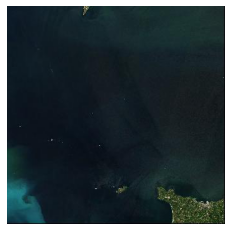

Displaying image: /home/jovyan/eodata/Sentinel-2/MSI/L2A/2020/06/23/S2B_MSIL2A_20200623T112119_N0214_R037_T30UVB_20200623T143258.SAFE/S2B_MSIL2A_20200623T112119_N0214_R037_T30UVB_20200623T143258-ql.jpg


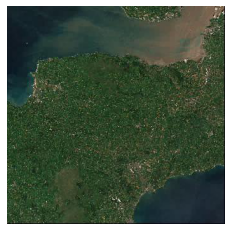

Displaying image: /home/jovyan/eodata/Sentinel-2/MSI/L2A/2020/06/25/S2A_MSIL2A_20200625T110631_N0214_R137_T30UXA_20200625T122333.SAFE/S2A_MSIL2A_20200625T110631_N0214_R137_T30UXA_20200625T122333-ql.jpg


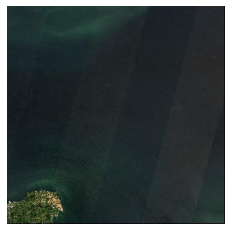

Displaying image: /home/jovyan/eodata/Sentinel-2/MSI/L2A/2020/06/23/S2B_MSIL2A_20200623T112119_N0214_R037_T30UUA_20200623T143258.SAFE/S2B_MSIL2A_20200623T112119_N0214_R037_T30UUA_20200623T143258-ql.jpg


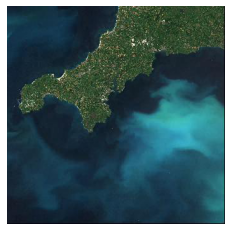

Displaying image: /home/jovyan/eodata/Sentinel-2/MSI/L2A/2020/06/23/S2B_MSIL2A_20200623T112119_N0214_R037_T30UWC_20200623T143258.SAFE/S2B_MSIL2A_20200623T112119_N0214_R037_T30UWC_20200623T143258-ql.jpg


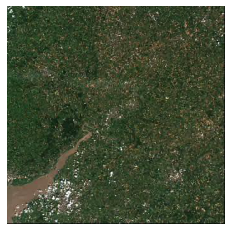

Displaying image: /home/jovyan/eodata/Sentinel-2/MSI/L2A/2020/06/25/S2A_MSIL2A_20200625T110631_N0214_R137_T30UXB_20200625T122333.SAFE/S2A_MSIL2A_20200625T110631_N0214_R137_T30UXB_20200625T122333-ql.jpg


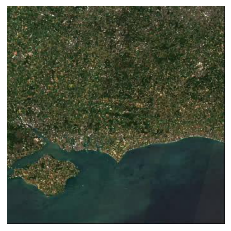

In [127]:
for tile in tile_safes:
    for safe_path in tile_safes[tile]:
        safe_name = os.path.basename(safe_path)
        img_file_name = f"{safe_name[:-5]}-ql.jpg"
        img_path = os.path.join(safe_path, img_file_name)
        print(f"Displaying image: {img_path}")
        with Image.open(img_path) as img:
            plt.imshow(img)
            plt.axis('off')
            plt.show()